In [1]:
from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import json
import os

from cell_inference.config import paths, params
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.transform.geometry_transformation import pol2cart, cart2pol
from cell_inference.cells.simulation import Simulation
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.utils.currents.ecp import EcpMod, EcpCell
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

%matplotlib inline

## Load data

In [2]:
DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'neuronal_model_491766131_tuned_Loc5')

STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics
n_summ_stats = np.load(STATS_PATH)['x'].shape[1]

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

['y', 'd', 'theta', 'h', 'phi']


### Transform labels

#### Orientation

In [3]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx0 = [inference_list.index(x) for x in ['h', 'phi']]
#     orient_idx2 = orient_idx0.copy()

direction_vec = True # represent orientation by vector on unit sphere
direction_vec = direction_vec and check_orient

label_list = inference_list.copy()
if direction_vec:
    orient_idx1 = list(range(len(inference_list) - 2, len(inference_list) + 1))
#     orient_idx2 = [orient_idx1[1], len(inference_list) + 1]
    label_list.remove('h')
    label_list.remove('phi')
    label_list += ['vx', 'vy', 'vz']
    for i in orient_idx1:
        ranges[label_list[i]] = [-1., 1.]

display_list = label_list.copy()
if direction_vec:
    display_list[orient_idx1[1]] = 'vy / h'
    display_list.append('phi')

#### y shift

In [4]:
has_yshift = 'y' in label_list
if has_yshift:
    ys_idx = label_list.index('y')
    label_list[ys_idx] = 'ys'
    display_list[display_list.index('y')] = 'y-shift'
    ranges['ys'] = [-150, 150] # set bound for normalization

#### Normalization

In [5]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

## Load model

In [6]:
import torch
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
# from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork

model_name = 'FCN_batch256'
if direction_vec:
    model_name += '_dv'
model_name += '.pth'
MODEL_PATH = os.path.join(TRIAL_PATH, model_name)

model = FullyConnectedNetwork(in_features=n_summ_stats, out_features=len(label_list))
model.load_state_dict(torch.load(MODEL_PATH))
device = torch.device("cpu")
model.eval()

FullyConnectedNetwork(
  (hidden_layers): Sequential(
    (0): Linear(in_features=40, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=124, bias=True)
    (3): ReLU()
    (4): Linear(in_features=124, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
  )
  (output_layers): Linear(in_features=16, out_features=6, bias=True)
)

## Select location parameter

In [7]:
loc_param_select = {'y': 0., 'd': 80., 'theta': 0., 'alpha': np.pi/8, 'h': 1., 'phi': 0.} # enter location parameters
loc_param_list = config_dict['Simulation_Parameters']['loc_param_list']

if 'd' in loc_param_select.keys() and 'theta' in loc_param_select.keys():
    loc_param_select['x'], loc_param_select['z'] = pol2cart(loc_param_select['d'], loc_param_select['theta'])
loc_param = np.array([loc_param_select[x] for x in loc_param_list])

## Get ground truth

#### from detailed model

In [8]:
DETAILED_PATH = 'cell_inference/resources/detailed'
model_name = 'neuronal_model_491766131'
file = os.path.join(DETAILED_PATH, model_name + '_Im.h5')

ecp_detailed = EcpMod(EcpCell(file=file), params.ELECTRODE_POSITION, move_cell=loc_param.reshape((2, 3)), min_distance=10.0)

detailed_lfp = ecp_detailed.calc_ecp().T

#### from stylized model

In [9]:
h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD_OBLIQUE, index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

# Biophysical parameters
filepath = './cell_inference/resources/biophys_parameters/'+model_name+'.json'
with open(filepath) as f:
    full_biophys = json.load(f)

# common parameters
biophys_param = [200, 50, 120] # Ra: basal, trunk, tuft
biophys_comm = {}

# geometry parameters
geo_param = [config_dict['Simulation_Parameters']['geo_param_default'][x] for x in config_dict['Simulation_Parameters']['geo_param_list']]

# Fixed gmax, not using gmax mapping file
gmax = 0.02

# stimulus parameter
stim_param = {'start': 2.}

sim = Simulation(geometry = geo_standard,
                 full_biophys = full_biophys,
                 electrodes = params.ELECTRODE_POSITION,
                 cell_type = CellTypes.ACTIVE_FULL,
                 biophys = biophys_param,
                 biophys_comm = biophys_comm,
                 loc_param = loc_param,
                 geo_param = geo_param,
                 spike_threshold = -30,
                 gmax = gmax,
                 stim_param = stim_param,
                 scale = 1.,
                 ncell = 1)

sim.run_neuron_sim()

start_idx = int(np.ceil(stim_param['start']/h.dt)) # ignore signal before
stylized_lfp = sim.get_lfp().T[start_idx:,:]

## Get LFP

In [10]:
filt_b, filt_a = signal.butter(params.BUTTERWORTH_ORDER,
                               params.FILTER_CRITICAL_FREQUENCY,
                               params.BANDFILTER_TYPE,
                               fs=params.FILTER_SAMPLING_RATE)

pk_tr_idx_in_window = 24  # 24*0.025=0.6 ms
y_idx = loc_param_list.index('y') if 'y' in inference_list else None

def process_lfp(lfp):
    bad = 0
    filtered_lfp = signal.lfilter(filt_b, filt_a, lfp, axis=0) # filter along time axis
#     filtered_lfp /= np.max(np.abs(filtered_lfp))
    try:
        start, end = get_spike_window(filtered_lfp, win_size=params.WINDOW_SIZE, align_at=pk_tr_idx_in_window)
        windowed_lfp = filtered_lfp[start:end,:]
        t = sim.t()[:params.WINDOW_SIZE]
    except ValueError:
        bad = 1
        t = h.dt * np.arange(filtered_lfp.shape[0])
    
    elec_pos = params.ELECTRODE_POSITION[:, :2]
    try:
        g_lfp, g_coords, y_c = build_lfp_grid(windowed_lfp, elec_pos, y_window_size=960.0)
    except ValueError:
        bad = 2
    
    if bad==1:
        output = (bad, filtered_lfp, t, elec_pos)
    elif bad==2:
        output = (bad, windowed_lfp, t, elec_pos)
    else:
        summ_stats = calculate_stats(g_lfp)
        if y_idx is not None:
            yshift = y_c - loc_param[y_idx]
        output = (bad, g_lfp, t, g_coords, summ_stats, y_c, yshift)
    return output

In [11]:
case_name = ['detailed ground truth', 'stylized ground truth']
lfp = [detailed_lfp, stylized_lfp]
output = [process_lfp(x) for x in lfp]
loc_param_pred = len(lfp) * [loc_param_select]

for i in range(len(lfp)):
    out = output[i]
    if not out[0]:
        case_name.append('Predicted stylized from ' + case_name[i])
        # model output
        pred = model(torch.Tensor(out[4]).to(device)).to("cpu").detach().numpy()
        for i, lb in enumerate(label_list):
            pred[i] = org_scale(pred[i], ranges[lb])
        # transform
        pred_list = label_list.copy()
        if has_yshift:
            pred[ys_idx] = out[5] - pred[ys_idx]
            pred_list[pred_list.index('ys')] = 'y'
        if direction_vec:
            pred[orient_idx1] = trivarnorm2unitsphere(pred[orient_idx1])
            pred = np.hstack([pred, unitsphere2hphi(pred[orient_idx1])[:, 1]])
            pred_list[pred_list.index('vy')] = 'h'
            pred_list.append('phi')
        loc_pred_dict = dict(zip(pred_list, pred))
        # get loc parameters
        if 'd' in loc_pred_dict.keys() and 'theta' in loc_pred_dict.keys():
            loc_pred_dict['x'], loc_pred_dict['z'] = pol2cart(loc_pred_dict['d'], loc_pred_dict['theta'])
        loc_param_pred.append(loc_pred_dict)
        loc_pred = [loc_pred_dict[x] if x in loc_pred_dict.keys() else loc_param_select[x] for x in loc_param_list]
        # get lfp
        lfp.append(sim.lfp[0].calc_ecp(move_cell=np.array(loc_pred).reshape((2, 3))).T[start_idx:,:])
        output.append(process_lfp(lfp[-1]))

## Plot LFP

Case 0 bad flag: 0
detailed ground truth
Parameters: {'y': 0.0, 'd': 80.0, 'theta': 0.0, 'alpha': 0.39269908169872414, 'h': 1.0, 'phi': 0.0, 'x': 0.0, 'z': 80.0}
Case 1 bad flag: 0
stylized ground truth
Parameters: {'y': 0.0, 'd': 80.0, 'theta': 0.0, 'alpha': 0.39269908169872414, 'h': 1.0, 'phi': 0.0, 'x': 0.0, 'z': 80.0}
Case 2 bad flag: 0
Predicted stylized from detailed ground truth
Parameters: {'y': -5.237503, 'd': 59.40874, 'theta': 0.12647621, 'vx': 0.02218563, 'h': 0.99962527, 'vz': 0.016038502, 'phi': 0.94485086, 'x': 7.493777, 'z': 58.934216}
Case 3 bad flag: 0
Predicted stylized from stylized ground truth
Parameters: {'y': 2.6124296, 'd': 94.29146, 'theta': -0.10201909, 'vx': -0.46414837, 'h': 0.8308915, 'vz': -0.30689675, 'phi': -2.1550076, 'x': -9.602851, 'z': 93.80119}


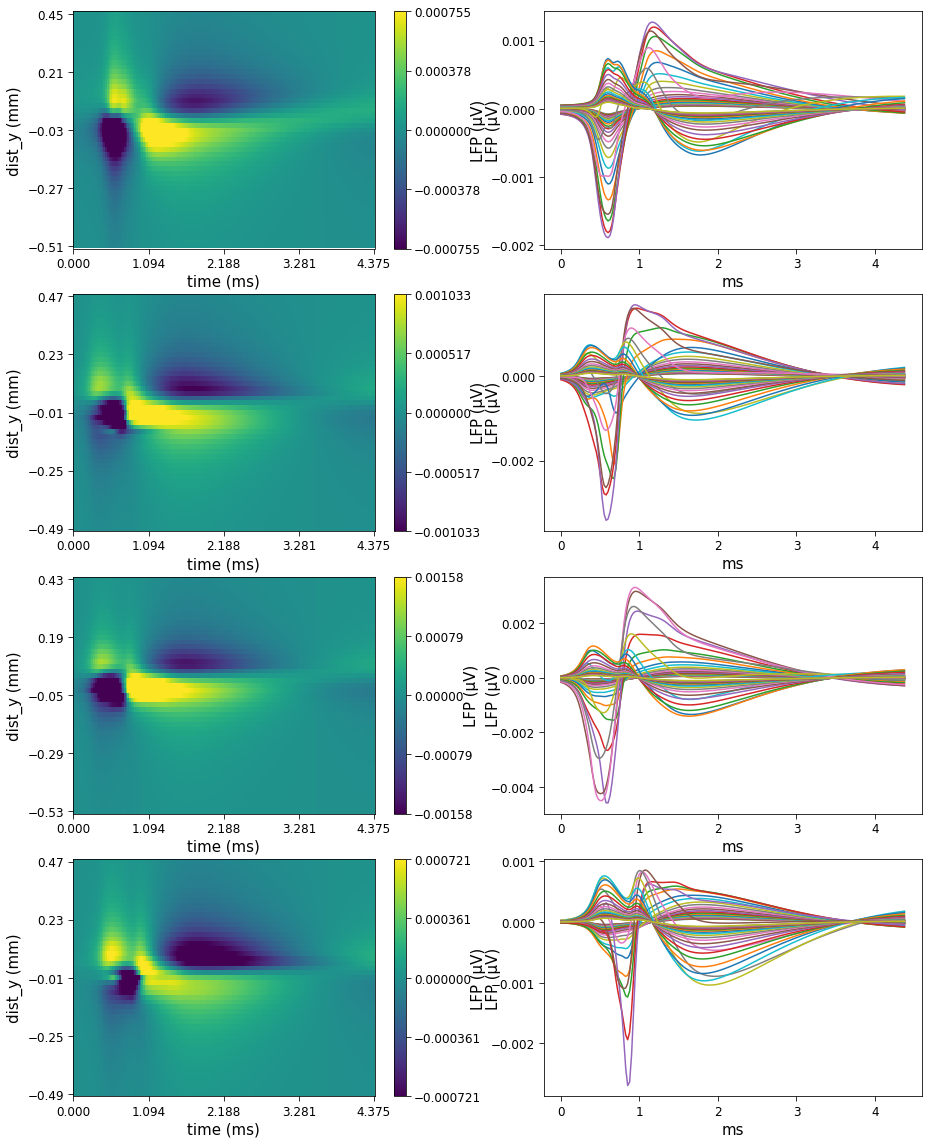

In [12]:
ix = 1
fontsize = 15
labelpad = -10
ticksize = 12
tick_length = 5
nbins = 5

nlfp = len(lfp)
plt.figure(figsize=(13, 4 * nlfp))
for i, out in enumerate(output):
    print("Case %d bad flag: %d" % (i, output[i][0]))
    print(case_name[i])
    print("Parameters: " + str(loc_param_pred[i]))
    d = output[i][1]
    t = output[i][2]
    coords = output[i][3]
    x_dist = np.unique(coords[:, 0])
    e_idx = coords[:, 0]==x_dist[ix]

    ax = plt.subplot(nlfp, 2, 2 * i + 1)
    _ = plot_lfp_heatmap(t=t, elec_d=coords[e_idx, 1], lfp=d[:, e_idx],
                         fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                         nbins=nbins, vlim='auto', axes = ax)
    
    ax = plt.subplot(nlfp, 2, 2 * i + 2)
    _ = plot_lfp_traces(t, d[:, e_idx],
                        fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                        nbins=nbins, axes = ax)
plt.tight_layout(h_pad=0., w_pad=-0.5)
plt.show()